<a href="https://colab.research.google.com/github/bangse94/hongik_ee/blob/master/mnist_my_handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ===========================
# import library
# ===========================
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("TensorFlow version : ", tf.__version__)
#===========================
# import mnist dataset
#===========================
(train_image, train_labels), (test_image, test_labels) = mnist.load_data()
#===========================
# reshape input data
#===========================
train_image = train_image.reshape(train_image.shape[0], 28, 28, 1)
test_image = test_image.reshape(test_image.shape[0], 28, 28, 1)
train_image = train_image.astype('float32')/255
test_image = test_image.astype('float32')/255
#===========================
# train labels
#===========================
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
#===========================
# model creation by sequential class
#===========================
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()
#===========================
# data augmentation
#===========================
datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
#===========================
# model compile and training
#===========================
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(train_image, train_labels, batch_size=128),
                    steps_per_epoch=train_image.shape[0] // 128,
                    validation_data=(test_image, test_labels),
                    epochs=24)
#===========================
# model evaluate
#===========================
acc = model.evaluate(test_image, test_labels)
print('evaluate accuracy:', acc[1])

#===========================
# save model
#===========================
model.save('mnist_model.h5')

TensorFlow version :  2.2.0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)       

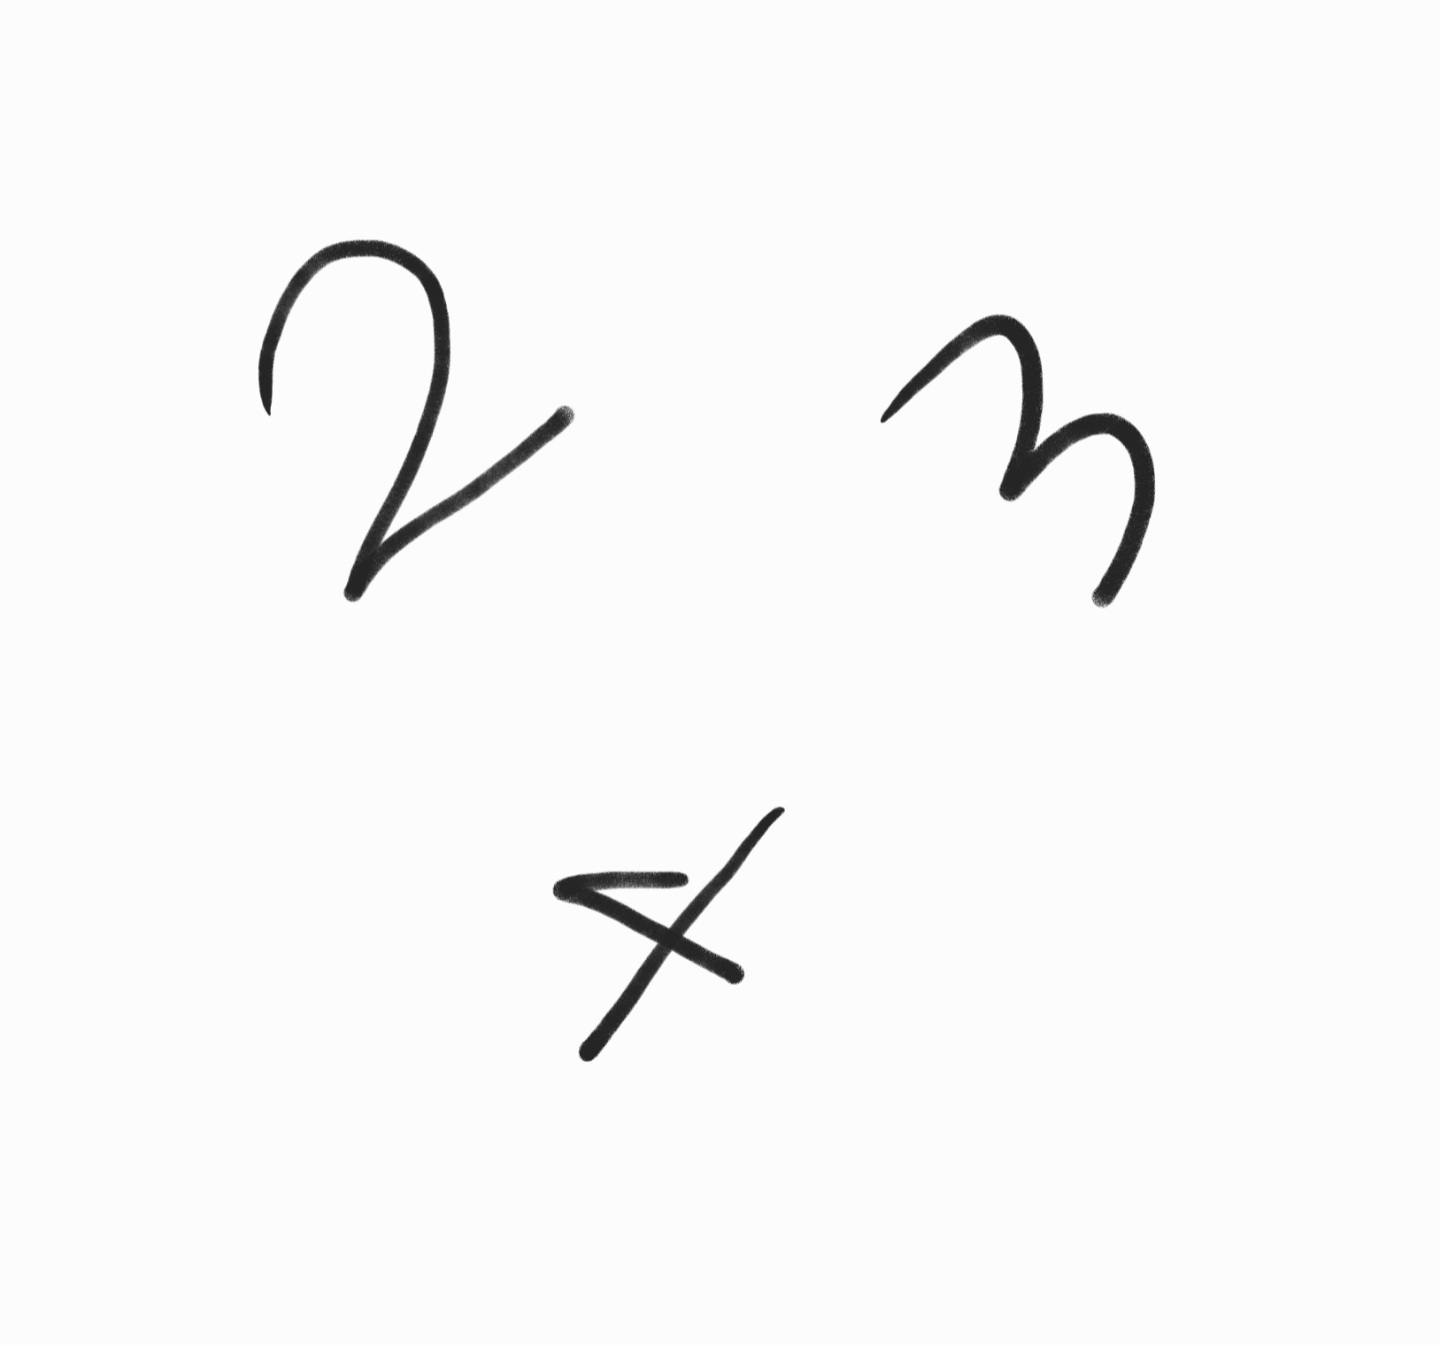

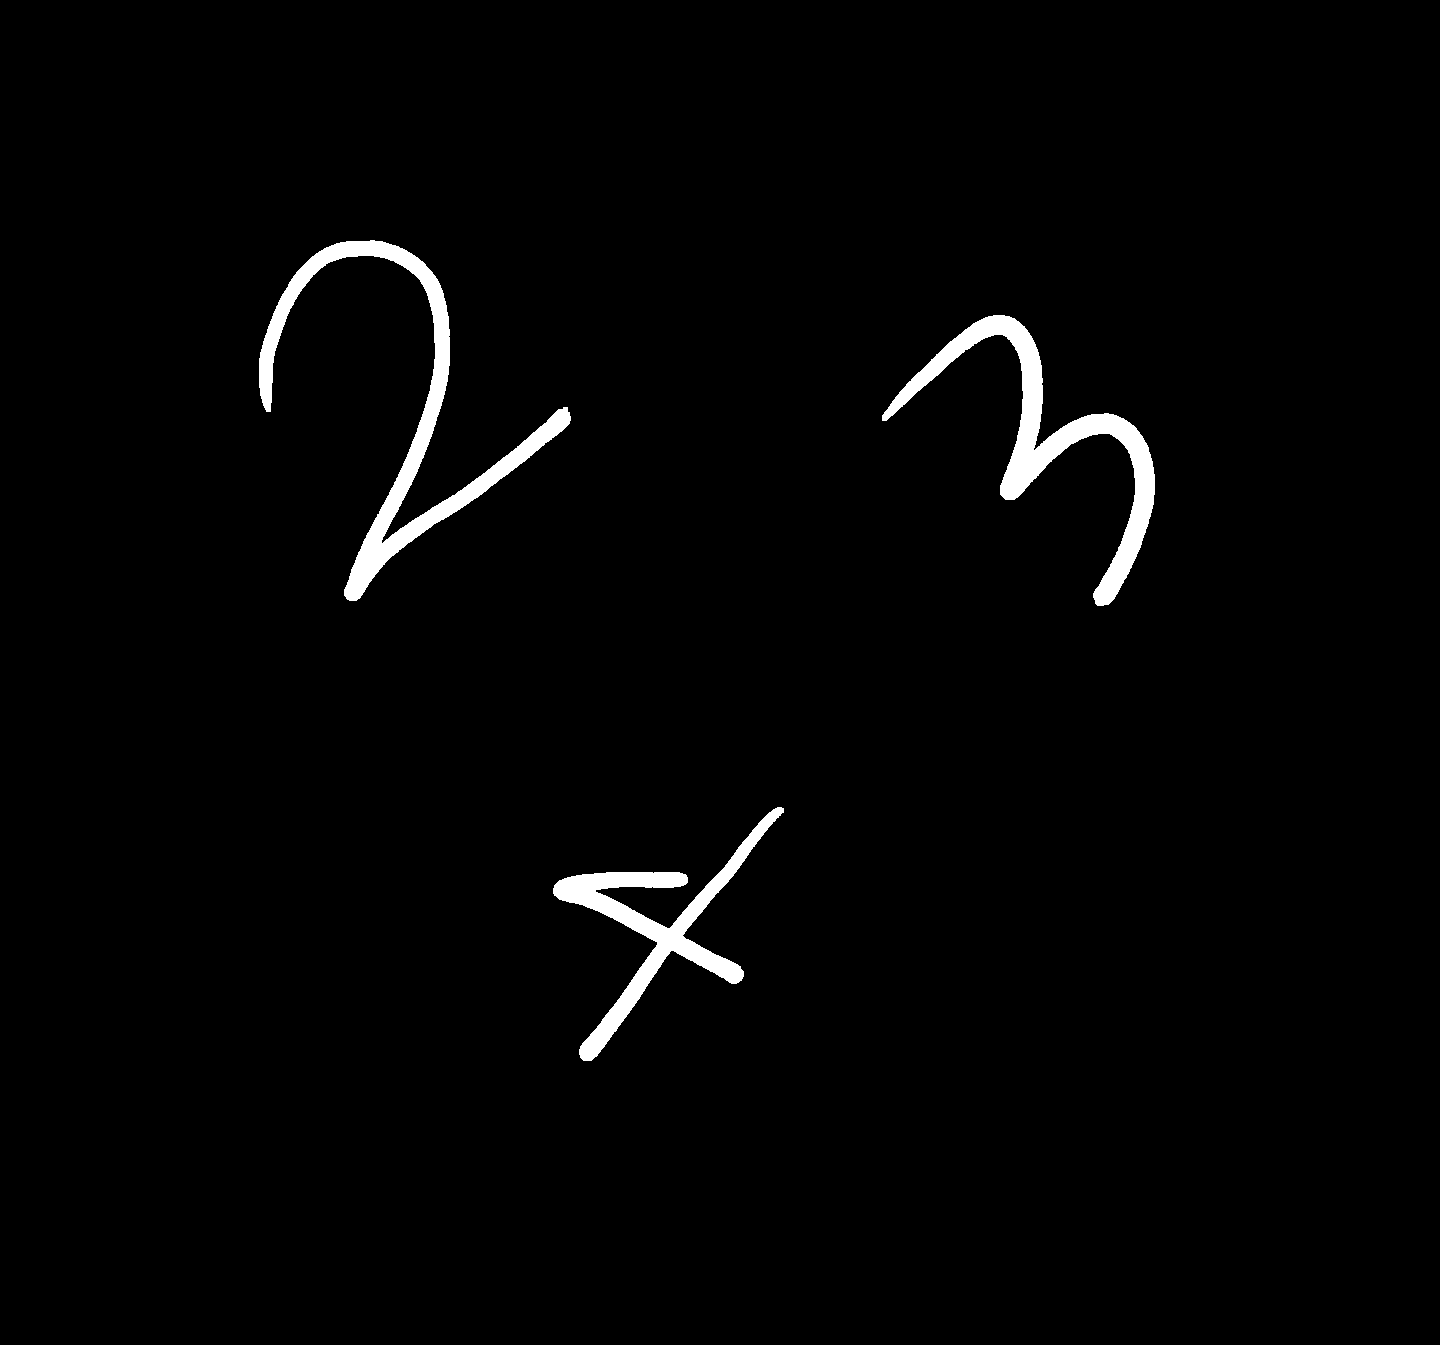

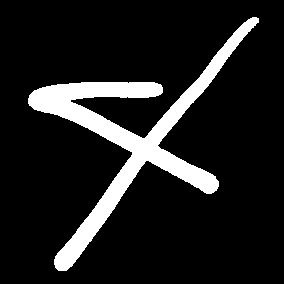

thils number is 4 



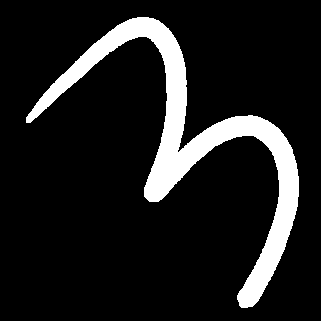

thils number is 3 



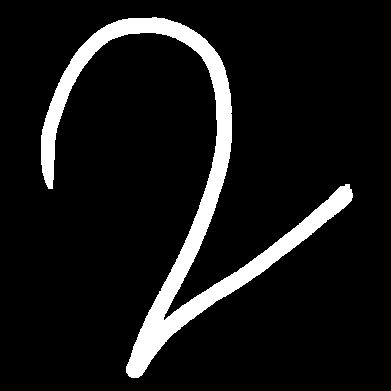

thils number is 2 



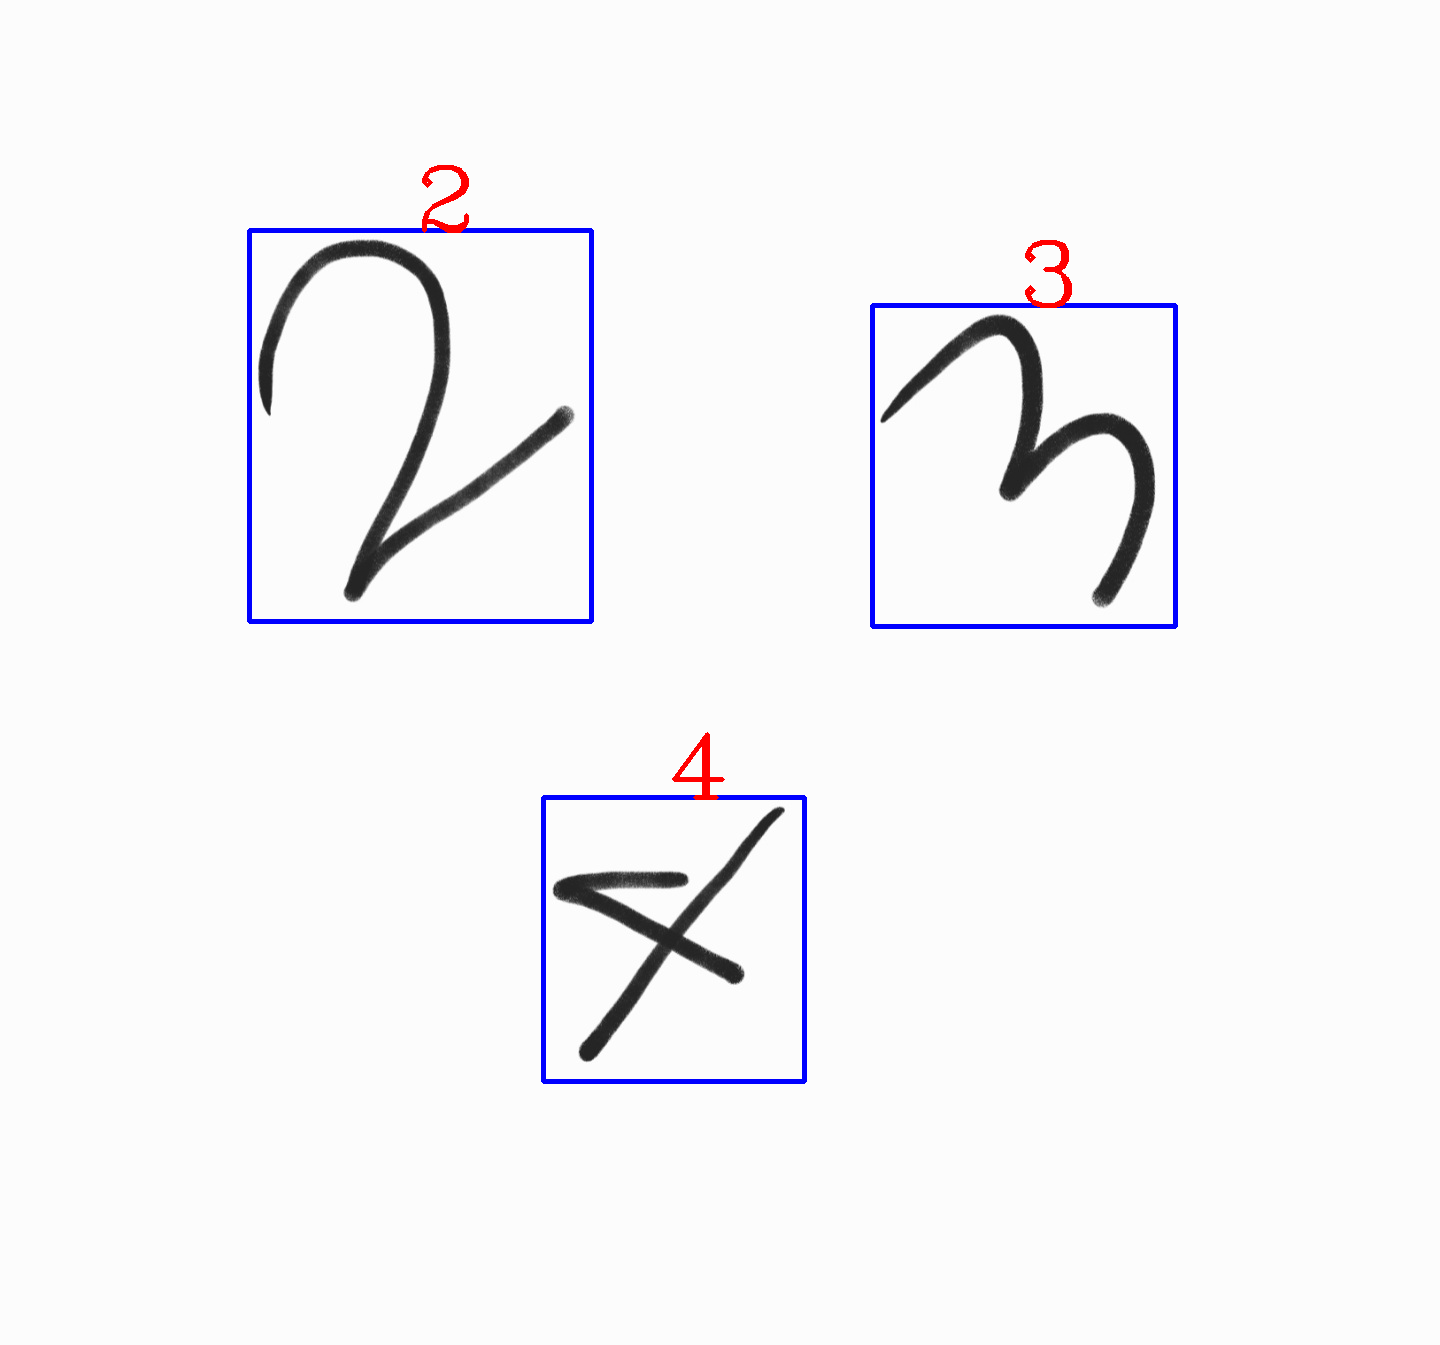

In [9]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#load model
model = load_model('mnist_model.h5')

class Trace():
    def GetImage(self, **kwargs):
        self.src_image = kwargs['image']
        self.img_color = cv2.imread("/content/"+ str(self.src_image), cv2.IMREAD_COLOR)

        return self.img_color

    def ImageProcessing(self, src_image):
        self.img_gray = cv2.cvtColor(src_image, cv2.COLOR_BGR2GRAY)
        _, self.img_binary = cv2.threshold(self.img_gray, 150, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        self.kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        self.img_binary = cv2.morphologyEx(self.img_binary, cv2.MORPH_OPEN, self.kernel)

        cv2_imshow(self.img_binary)
        return self.img_binary
    
    def Detect(self, binary_img):
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x_cont, y_cont, width, height = cv2.boundingRect(contour)

            length = max(width, height) + 30
            img_num = np.zeros((length, length, 1), np.uint8)

    #정사각형으로 window를 만들어주자
            x_win, y_win = x_cont-(length-width)//2, y_cont-(length-height)//2

    #test공간에 binary image input    
            img_num = img_binary[y_win:y_win+length,x_win:x_win+length]
            kernel = np.zeros((5,5), np.uint8)
            img_num = cv2.morphologyEx(img_num, cv2.MORPH_DILATE, kernel)
            cv2_imshow(img_num)

            img_num = cv2.resize(img_num, (28, 28), interpolation=cv2.INTER_AREA)/255
            img_input = img_num.reshape(1, 28, 28, 1)
 
            predict = model.predict(img_input)
            answer = np.argmax(predict)
            print("thils number is " +str(answer),"\n")

    #color image에 sketch window
            cv2.rectangle(img_color, (x_cont-10, y_cont-10), (x_cont+width+20, y_cont+height+20), (255, 0, 0), 3)

    #window 위에 predict 표시
    #cv2.putText(src, org, FontFace, Fontscale, color, thickness,... )
            cv2.putText(img_color, str(answer), (x_cont+int(width*0.5), y_cont-10), cv2.FONT_HERSHEY_COMPLEX, 3, (0, 0, 255), 3)

        return img_color


mnist = Trace()

img_color = Trace.GetImage(mnist,image='numbers2.jpg')
cv2_imshow(img_color)
img_binary = Trace.ImageProcessing(mnist,img_color)
Trace.Detect(mnist,img_binary)
cv2_imshow(img_color)